# Parameter Tuning of the LGN Inputs

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)

In this section, we show how to find more appropiate values using a grid-search on the **syn_weight** parameter. We will run the simulation multiple times in a row, each time increasing/decreasing the **syn_weight** by some factor depending on the edge's target cell type. In each iteration we'll record the updated **syn_weight** and the target cell type's mean firing rate so we can plot the results at the end. 

Once we have a better idea of the feed-forward **syn_weight** values that are best for different cell models it will be trivial to update the *lgn_l4_edge_types.csv* **syn_weight** values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest
import warnings

from bmtk.simulator import pointnet
from bmtk.analyzer.spike_trains import plot_rates_boxplot
from bmtk.analyzer.spike_trains import spike_statistics

[INFO] [2022.7.17 7:27:13 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.7.17 7:27:13 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.1
 Built: Jan  1 2022 23:06:15

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



#### Initial simulation with feedforward connections only

The full model we built in the previous chapter contained multiple sets of synaptic connections (_aka_ edge-types): recurrent connections and feedforward connections from the "LGN" and "BKG" populations of cells. In even larger models the types of connections can grow exponentially. However with the SONATA network format it is easy to only run a subset of the entire network, which can simplify the process of trying to optimize cell and synaptic model parameters for results we expect. 

In this case we want to optimize the **syn_weight** parameter that controls synaptic weights between cells. But only do so for the **LNG** --> **L4** feedforward connections. (Later we can do the same for BKG --> L4 and L4 --> L4 connections). To test and optimize the simulation for only the LGN --> L4 connections we just need to create a special configuration file that only contains the required nodes and edges. Here we copied an existing one, modified it as follows, and renamed it *config.simulation_pointnet.feedforward.json*.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.feedforward.csv"
      }
    ]
  }
```

**Note** that we also made a copy of *lgn_l4_edge_types.csv* and named it *lgn_l4_edge_types.feedforward.csv*. This is so we can readily test and adjust certain cell properties like **syn_weight** by altering the csv file, without having to lose our original state.

When we run the model with LGN feedforward inputs only we can see the firing rates on a population-by-population basis.

In [2]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-17 07:27:20,860 [INFO] Created log file
2022-07-17 07:27:20,884 [INFO] Batch processing nodes for l4/0.
2022-07-17 07:27:20,978 [INFO] Batch processing nodes for lgn/0.
2022-07-17 07:27:21,001 [INFO] Setting up output directory
2022-07-17 07:27:21,002 [INFO] Building cells.
2022-07-17 07:27:21,024 [INFO] Building recurrent connections
2022-07-17 07:27:21,025 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-17 07:27:26,345 [INFO] Network created.
2022-07-17 07:27:26,394 [INFO] Starting Simulation
2022-07-17 07:27:31,634 [INFO] Simulation finished, finalizing results.
2022-07-17 07:27:31,995 [INFO] Done.


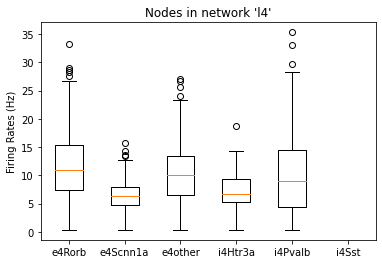

In [3]:
from bmtk.analyzer.spike_trains import plot_rates_boxplot

_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

The firing rates have a wide spread and need to be adjusted. For example we want the excitatory e4 populations to fire at a rate ~5Hz while the inhibitory i4 should be ~ 15Hz baseline. Based on these initial results, it looks like we want to decrease the **syn_weight**s of the e4 population while increasing the weights for the i4 population.


#### Readjusting synaptic weights at run-time

This can be done by rebuilding the network, but for larger models this can be time consuming, and we will probably need to adjust the weights multiple times. Instead, the BMTK has a way of adjusting the synaptic weights dynamically at simulation time. In the SONATA edges file for LGN --> L4 connections we include an optional column called **weight_function**:

In [4]:
edge_types_df = pd.read_csv('network/lgn_l4_edge_types.feedforward.csv', sep=' ')
edge_types_df.style.applymap(lambda *_: 'background-color: yellow', 
                             subset=pd.IndexSlice[:, ['syn_weight', 'weight_function']])

,edge_type_id,target_query,source_query,dynamics_params,syn_weight,model_template,delay,weight_function
0,100,model_name=='Sst_501282204',*,i2e.json,1.000000,static_synapse,1.700000,set_syn_weight
1,101,model_name=='Rorb_314642645',*,e2e.json,1.000000,static_synapse,1.700000,set_syn_weight
2,102,model_name=='Scnn1a_517982558',*,e2e.json,1.000000,static_synapse,1.700000,set_syn_weight
3,103,model_name=='Htr3a_474626527',*,i2e.json,1.000000,static_synapse,1.700000,set_syn_weight
4,104,model_name=='other_483018019',*,e2e.json,1.000000,static_synapse,1.700000,set_syn_weight
5,105,model_name=='Pvalb_478958894',*,i2e.json,1.000000,static_synapse,1.700000,set_syn_weight


*set_syn_weight* is a built-in function that is used by bmtk to calculate synaptic weights for pairs of source/target cells. *set_syn_weight* takes in a table of edge and cell properties and returns a list of updated synaptic weights, by default simply by returning the **syn_weight** times the number of actual synapses (which defaults to 1 if not explicity stated).

```python
def default_weight_fnc(edge_props, source_nodes, target_nodes):
    return np.array(edge_props['syn_weight']*edge_props.nsyns)
```

However, with bmtk we can override this behavior. Here the ```@synaptic_weight``` is a python decorator that we can use to overwrite the default *set_syn_weight* function with one of our own. For the initial implementation we can see what happens when we reduce the **syn_weight** for the e4Rorb population.

In [5]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight

i = 1
@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    # Check the target's cell_line. If it is e4Rorb then reduce the syn-weight value,
    # otherwise just return the function like original.
    trg_type = target_nodes['cell_line'].unique()[0]
   
    if trg_type == 'e4Rorb':
        return np.full(len(edge_props), fill_value=0.68)*np.array(edge_props['nsyns'])
    else:
        return np.array(edge_props['syn_weight']*edge_props['nsyns'])
    
configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-17 07:27:58,387 [INFO] Created log file
2022-07-17 07:27:58,414 [INFO] Batch processing nodes for l4/0.
2022-07-17 07:27:58,488 [INFO] Batch processing nodes for lgn/0.
2022-07-17 07:27:58,548 [INFO] Setting up output directory
2022-07-17 07:27:58,549 [INFO] Building cells.
2022-07-17 07:27:58,566 [INFO] Building recurrent connections
2022-07-17 07:27:58,567 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-17 07:28:03,524 [INFO] Network created.
2022-07-17 07:28:03,555 [INFO] Starting Simulation
2022-07-17 07:28:08,458 [INFO] Simulation finished, finalizing results.
2022-07-17 07:28:08,743 [INFO] Done.


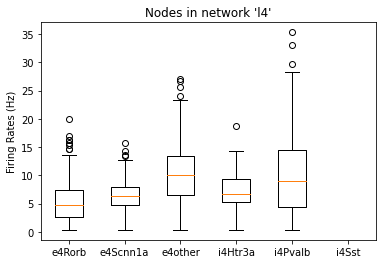

In [6]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

Now, the e4Rorb firing rates are closer to our target firing rate of ~5 Hz. From there we can continue to modify *set_syn_weight* to take into account the other cell populations. But we would need to manually execute the simulation multiple times, each time adjusting either the *set_syn_weight* function or the **syn_weight** parameter in the *edge_types.csv* file until we find the results we want. 

#### Grid search

Alternatively we can automate the search process for the right **syn_weight** values by running the simulation multiple times in a row, adjusting *set_syn_weight* to return different synaptic weights at each iteration.

In the code below we will run the simulation four different times. At each iteration *set_syn_weight* updates the the **syn_weight** on a population-by-population basis from the values in the ```grid_search``` table. After each time the simulation is run, we call the ```spike_statistics()``` function to find the mean firing-rates for said simulation's results. The firing-rate vs. syn_weight results are saved into ```fr_table``` which can then be used to see what values of **syn_weight** produce the most realistic firing rates for each given population. 

In [7]:
from bmtk.analyzer.spike_trains import spike_statistics
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight
from bmtk.simulator import pointnet
from bmtk.analyzer.spike_trains import plot_rates_boxplot


# Contains new syn_weight values for each iteration, e.g., index 0 is for first iteration, index 1 
# for second iteration, etc.
grid_search = {
    'e4Rorb': [0.3, 0.6, 0.7, 1.0],
    'e4Scnn1a': [0.3, 0.6, 0.9, 1.2],
    'e4other': [0.3, 0.5, 0.7, 0.9],
    'i4Htr3a': [1.0, 2.0, 3.0, 4.0],
    'i4Pvalb': [0.2, 0.8, 1.1, 1.3],
    'i4Sst': [2.0, 4.0, 6.0, 8.0]
}


# Keeps track of current iteration, plus each iteration's weights and firing rates for graphing later
current_itr = 0
weights_table = {cell_line: [] for cell_line in grid_search.keys()}
fr_table = {cell_line: [] for cell_line in grid_search.keys()}


@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    # Find "cell_line" for targets and get new syn_weight value for current iteration
    target_type = target_nodes['cell_line'].unique()[0]
    new_syn_weight = grid_search[target_type][current_itr]
    
    # Save the updated weights at each iteration
    weights_table[target_type].append(new_syn_weight)
    
    # Return new weights
    return np.array(new_syn_weight*edge_props.nsyns)
    

for i in range(4):
    current_itr = i
    
    print('>> Running iteration {}'.format(i+1))
    configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
    configure.build_env()

    graph = pointnet.PointNetwork.from_config(configure)
    sim = pointnet.PointSimulator.from_config(configure, graph)
    sim.run()
   
    spike_stats_df = spike_statistics('output_feedforward/spikes.h5', simulation=sim, group_by='cell_line', populations='l4')
    for cell_line, fr in spike_stats_df['firing_rate']['mean'].items():
        fr_table[cell_line].append(fr)


>> Running iteration 1
2022-07-17 07:28:42,639 [INFO] Created log file
2022-07-17 07:28:42,661 [INFO] Batch processing nodes for l4/0.
2022-07-17 07:28:42,739 [INFO] Batch processing nodes for lgn/0.
2022-07-17 07:28:42,794 [INFO] Setting up output directory
2022-07-17 07:28:42,794 [INFO] Building cells.
2022-07-17 07:28:42,808 [INFO] Building recurrent connections
2022-07-17 07:28:42,809 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-17 07:28:48,035 [INFO] Network created.
2022-07-17 07:28:48,063 [INFO] Starting Simulation
2022-07-17 07:28:53,031 [INFO] Simulation finished, finalizing results.
2022-07-17 07:28:53,047 [INFO] Done.
>> Running iteration 2
2022-07-17 07:28:53,286 [INFO] Created log file
2022-07-17 07:28:53,306 [INFO] Batch processing nodes for l4/0.
2022-07-17 07:28:53,380 [INFO] Batch processing nodes for lgn/0.
2022-07-17 07:28:53,437 [INFO] Setting up output directory
2022-07-17 07:28:53,438 [INFO] Building cells.
2022-07-17 07:28:53,452 [INFO] Building 

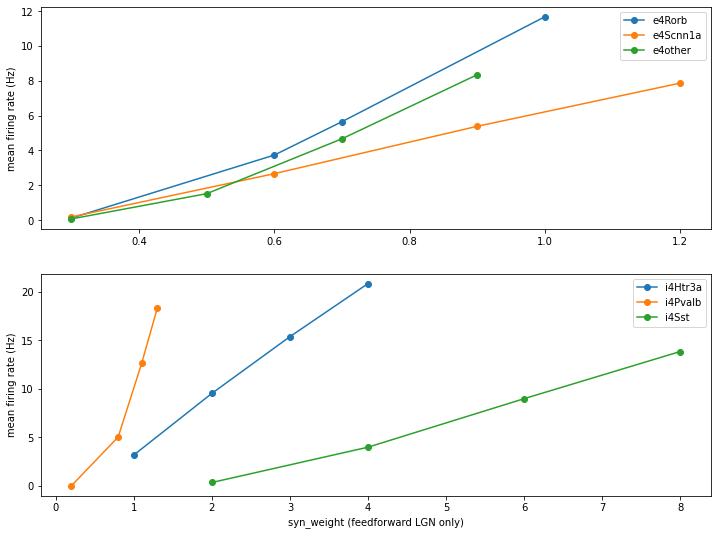

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))
for cell_line, weights in weights_table.items():
    firing_rates = fr_table[cell_line]
    # Since the exc and inh have different syn_weight scales let's
    # plot them separately.
    if cell_line.startswith('e'):
        ax[0].plot(weights, firing_rates, '-o', label=cell_line)
    else:
        ax[1].plot(weights, firing_rates, '-o', label=cell_line)

ax[1].set_xlabel('syn_weight (feedforward LGN only)')
ax[0].set_ylabel('mean firing rate (Hz)')
ax[1].set_ylabel('mean firing rate (Hz)')
ax[0].legend()
ax[1].legend() 
plt.show()

From here we can plug our desired **syn_weight** values back into the main *edge_types.csv* file, then proceed in a similar fashion to optimize other connections types and even other parameters. Using these tools, we can also implement more sophisticated optimization methods, such as the conjugate gradient method. For the "l4" model with "lgn" and "bkg" inputs, the main *edge*s files have already been optimized - but hopefully this will help with other novel models.

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)